# Lifelong Planning A* on Grids

You will implement a dynamic path planner for a point robot in a 2D terrain discretized as a grid world. The grid has 8-point connectivity; the neighbors of a given cell generally include the eight surrounding cells (or a subset of them, if the cell is on the boundary). The world is surrounded by four impassable walls, and it also contains a variety of terrain features. 

We can represent the grid using a 2D NumPy array indicating the status of each cell. Each cell takes on a value from the set $\{0, 1, 2, 3\}$ indicating the terrain feature at that cell. We provide four example grid worlds with different arrangements of terrain, all saved as `.npy` files. You can load an environment using `numpy.load()` and visualize it using `visualize_grid_world()`.

In [41]:
import numpy as np
import matplotlib.pyplot as plt

from matplotlib.patches import Patch
from matplotlib.colors import ListedColormap
from matplotlib.animation import FuncAnimation

from pathlib import Path
from enum import IntEnum
from heapq import *

In [42]:
class Environment(IntEnum):
    FLATLAND = 0
    POND = 1
    MOUNTAIN = 2
    OBSTACLE = 3
    EXPANDED = 4


def highlight_start_and_end(grid, cell, val):
    c_x, c_y = cell
    for x in range(grid.shape[0]):
        for y in range(grid.shape[1]):
            if np.sqrt((x - c_x) ** 2 + (y - c_y) ** 2) < 5:
                grid[int(x), int(y)] = val

    return grid


def visualize_grid_world(grid):
    _, ax = plt.subplots()
    grid_world = np.copy(grid)

    cmap = ListedColormap([
        "#006600",  # Flatland
        "#4d94ff",  # Pond
        "#FFA500",  # Mountain
        "#333333",  # Obstacle
    ])

    ax.imshow(grid_world, cmap=cmap)
    legend_elements = [
        Patch(facecolor="#006600", label="Flatland"),
        Patch(facecolor="#4d94ff", label="Pond"),
        Patch(facecolor="#FFA500", label="Mountain"),
        Patch(facecolor="#333333", label="Obstacle"),
        ]
    
    ax.set_title(f"Grid World Visualization")
    ax.legend(handles=legend_elements, 
              loc='upper center', bbox_to_anchor=(0.5, 0), ncol=4)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    plt.show()


def visualize_path(grid, start, goal, path):
    fig, ax = plt.subplots()
    grid_world = np.copy(grid)

    cmap = ListedColormap([
        "#006600",  # Flatland
        "#4d94ff",  # Pond
        "#FFA500",  # Mountain
        "#333333",  # Obstacle
        "#00AA00",  # Start & Goal
    ])

    grid_world = highlight_start_and_end(grid_world, start, len(cmap.colors) - 1)
    grid_world = highlight_start_and_end(grid_world, goal, len(cmap.colors) - 1)

    ax.imshow(grid_world, cmap=cmap)

    legend_elements = [
        Patch(facecolor="#006600", label="Flatland"),
        Patch(facecolor="#4d94ff", label="Pond"),
        Patch(facecolor="#FFA500", label="Mountain"),
        Patch(facecolor="#333333", label="Obstacle"),
        Patch(facecolor="#86592d", label="Expanded"),
        ]

    path_line, = ax.plot([], [], color='#FF0000', label='Path')

    if path:
        path_x, path_y = zip(*path)
        gw, = ax.plot(path_y, path_x, color='#FF0000', label='Path')
        legend_elements.append(Patch(facecolor='#FF0000', label='Path'))

    ax.set_title(f"Grid World Path Planning Result")
    ax.legend(
        handles=legend_elements, 
        loc='upper center', 
        bbox_to_anchor=(0.5, 0), 
        ncol=3
        )
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    plt.show()


def visualize_expanded(grid, start, goal, expanded, path):
    fig, ax = plt.subplots()
    grid_world = np.copy(grid)

    cmap = ListedColormap([
        "#006600",  # Flatland
        "#4d94ff",  # Pond
        "#FFA500",  # Mountain
        "#333333",  # Obstacle
        "#86592d",  # Expanded
        "#00AA00",  # Start & Goal
    ])

    grid_world = highlight_start_and_end(grid_world, start, len(cmap.colors) - 1)
    grid_world = highlight_start_and_end(grid_world, goal, len(cmap.colors) - 1)

    if path:
        path_x, path_y = zip(*path)
        gw, = ax.plot(path_y, path_x, color='#FF0000', label='Path')

    # dumb bug fix
    fix_bug = grid_world[0, -1]
    grid_world[0, 3] = 4
    gw = ax.imshow(grid_world, cmap=cmap)
    grid_world[0, 3] = fix_bug

    legend_elements = [
        Patch(facecolor="#006600", label="Flatland"),
        Patch(facecolor="#4d94ff", label="Pond"),
        Patch(facecolor="#FFA500", label="Mountain"),
        Patch(facecolor="#333333", label="Obstacle"),
        Patch(facecolor="#86592d", label="Expanded"),
        Patch(facecolor='#FF0000', label='Path')
        ]

    expanded = [s for s in expanded if len(s) > 0]
    all_x, all_y = [], []

    for s in expanded:
        x, y = s
        all_x.append(x)
        all_y.append(y)
    grid_world[all_x, all_y] = Environment.EXPANDED
    gw.set_array(grid_world)

    ax.set_title(f"Grid World Expanded Cells Result")
    ax.legend(
        handles=legend_elements, 
        loc='upper center', 
        bbox_to_anchor=(0.5, 0), 
        ncol=3
        )
    
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    plt.show()


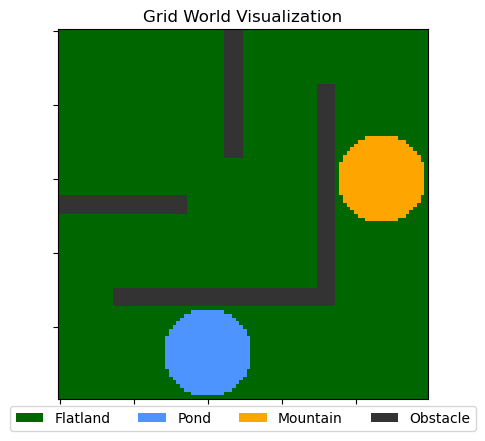

In [43]:
grid = np.load(f"worlds/world_1.npy")
visualize_grid_world(grid)

# `LPA_Planner` Class

You will complete the following `LPA_Planner` class. When we initialize a `LPA_Planner` object, we provide the `grid`, as well as `start` and `goal` coordinate tuples on the grid. In `__init__()`, we initialize the arrays `gridv`, `gridg`, and `gridh`. These contain, respectively, the $v$ values, $g$ values, and $h$ values (Euclidean distance) of all cells in the grid.

We also initialize `open_list`, which will be maintained using [`heapq`](https://docs.python.org/3/library/heapq.html) library functions, and insert the `start` node into it. Notice that each `open_list` item is a tuple containing the *key* of a node (which is used to order the list items) and then the node itself. Finally, we initialize a `parents` dictionary that will eventually contain the *parent* of each node seen. 

**Helper functions.** The `key()` of a node $n$ is computed as $(\min(v(n),g(n))+h(n), \min(v(n),g(n)))$. It is a tuple so that the second value is used if the first one is tied between two nodes. `cost()` returns the cost value of a node (determined by its feature), and `neighbors()` returns a list of all neighboring nodes. 

## Part 1: `update_node()`

Implement `update_node()`, which should perform the following updates given a `node` $n$:

* Set $g(n) = \min (v(p) + d \times c(n))$, where $p$ is a neighbor of $n$ and $c(n)$ is just the `cost` of $n$. The weight $d$ is $1$ if $p$ is a cardinal neighbor of $n$ and $\sqrt 2$ if $p$ is a diagonal neighbor. Also record the min neighbor of $n$ in the `parents` dictionary.

* If $n$ is currently in the open list with an outdated key, remove it.

* If $g(n) \neq v(n)$ and $n$ is not in the open list, insert it with its current key.

## Part 2: `compute_path()`

Implement `compute_path()`, which will compute and return an optimal path starting from the current state of the grid's values and open list. It should also define and update a *list* of expanded nodes. The following steps should then be performed while the first node in the open list has a smaller key than that of the goal, or while the goal remains inconsistent:

* Pop the first node off the open list. If it is overconsistent, set $v=g$ to make it consistent. Otherwise, set $v=\infty$ and call `update_node()` on it.

* Call `update_node()` on each of the neighbors of the popped node (make sure to skip the `start` node).

* Add the popped node to the `expanded` list.

Once the loop terminates, you can follow the `parents` dictionary of pointers from the goal back to the start node. You can then reverse this to return the `path` list, along with the `expanded` list.

In [54]:
class LPA_Planner():
    def __init__(self, grid, start, goal):
        self.grid = grid
        self.start = start 
        self.goal = goal 

        self.gridv = np.inf*np.ones((self.grid.shape[0], self.grid.shape[1]))
        self.gridg = np.inf*np.ones((self.grid.shape[0], self.grid.shape[1]))
        self.gridg[self.start] = 0 

        self.gridh = np.ones((self.grid.shape[0], self.grid.shape[1]))
        for i in range(self.grid.shape[0]):
            for j in range(self.grid.shape[1]):
                self.gridh[i,j] = 0.5 * ((self.goal[0]-i)**2 + (self.goal[1]-j)**2)**0.5

        self.open_list = [(self.key(self.start), self.start)]
        heapify(self.open_list)
        self.parents = {self.start: None}


    def key(self, node):
        return (min(self.gridv[node], self.gridg[node]) + self.gridh[node], 
                min(self.gridv[node], self.gridg[node]))


    def cost(self, node):
        if self.grid[node] == Environment.FLATLAND:
            return 1
        elif self.grid[node] == Environment.POND:
            return 0.5
        elif self.grid[node] == Environment.MOUNTAIN:
            return 2
        elif self.grid[node] == Environment.OBSTACLE:
            return np.inf


    def neighbors(self, node):
        neighbors = []
        adjacent = [[0, 1], [1, 0], [0, -1], [-1, 0],
                    [1, 1], [1, -1], [-1, 1], [-1, -1]]
        
        x, y = node
        for i, j in adjacent:
            if x + i >= 0 and x + i < self.grid.shape[0] and \
               y + j >= 0 and y + j < self.grid.shape[1] and \
               self.grid[x + i, y + j] != Environment.OBSTACLE:
                neighbors.append((x + i, y + j))
        return neighbors


    def update_costs(self, rows, cols, feature):
        self.grid[rows, cols] = feature
        for i in range(len(rows)):
            self.update_node((rows[i], cols[i]))


    def update_node(self, node):
        neighbors = self.neighbors(node)
        cost = self.cost(node)
        minimum = np.inf
        min_parent = None
        x_1, y_1 = node
        for n in neighbors:
            x_2, y_2 = n
            dist = abs(x_1 - x_2) + abs(y_1-y_2)
            d = np.sqrt(2) if dist > 1 else 1
            update = self.gridv[n] + (d * cost) 
            
            if update < minimum: 
                minimum = update
                min_parent = n
        
        self.gridg[node] = minimum
        list_entry = (self.key(node), node)

        if node in (entry[1] for entry in self.open_list):
            self.open_list = [entry for entry in self.open_list if entry[1] != node]

        if self.gridg[node] != self.gridv[node]:
             heappush(self.open_list, list_entry)
        
        self.parents[node] = min_parent


    def compute_path(self):
        expanded = []
        path = []
     
        while (self.open_list[0][0] <= self.key(self.goal)) or (self.gridg[self.goal] != self.gridv[self.goal]):
            curr = heappop(self.open_list)[1]
            if self.gridv[curr] > self.gridg[curr]:
                self.gridv[curr] = self.gridg[curr]
            else:
                self.gridv[curr] = np.inf
                self.update_node(curr)
            
            neighbors = self.neighbors(curr)
            for n in neighbors:
                if n != self.start:
                    self.update_node(n)
            expanded.append(curr)
     
        path.append(self.goal)
        x = self.goal
        while x in self.parents and self.parents[x] is not None:
            path.append(self.parents[x])
            x = self.parents[x]
        path.reverse()
        return path, expanded


In [55]:
def main(searcher):
    path, expanded = searcher.compute_path()
    path_cost = 0
    for i in range(1,len(path)):
        d = 1 if path[i][0] == path[i-1][0] or path[i][1] == path[i-1][1] else np.sqrt(2)
        path_cost += d*searcher.cost(path[i])

    print(f"Path length: {len(path)}")
    print(f"Path cost: {path_cost}")
    print(f"Number of expanded states: {len(expanded)}")
    visualize_path(searcher.grid, searcher.start, searcher.goal, path)
    visualize_expanded(searcher.grid, searcher.start, searcher.goal, expanded, path)

After you finish your implementation, you can test it out by loading a sample world, specifying the start and goal locations, and then creating a new `LPA_Planner` object. You can then run the provided `main()` function to compute a path and show the results. An example is shown below with world 1 and start and goal locations $(10,10)$ and $(90,90)$. 

If all goes well, a path should be found by your planner. You should see the path length and cost, number of expanded states, and two figures, one showing the path and the other also showing expanded cells.

Initial planning...
Path length: 141
Path cost: 152.52438661763946
Number of expanded states: 8240


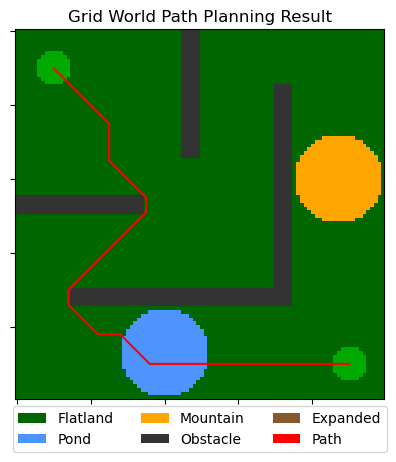

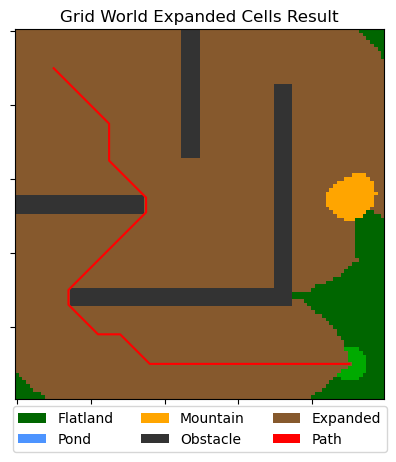

In [56]:
grid = np.load(f"worlds/world_1.npy")
start = (10, 10)
goal = (90, 90)

searcher = LPA_Planner(grid, start, goal)
print("Initial planning...")
main(searcher)

## Part 3: Analysis

Continuing from the example above, perform each of the following tasks in sequence. **It is important that you do not reset or create a new `LPA_Planner` object for each task.** The whole point of LPA is that its state persists, allowing it to do fast replanning. Show the outputs and answer the follow-up questions. 

* Change the goal from $(90,90)$ to $(80,85)$ and recompute the optimal path. Report and explain your observations about the set of expanded states in the new search. 

* Suppose we've discovered a new `MOUNTAIN` from rows 75 to 85 and from columns 60 to 70. Use the `update_costs()` function in `LPA_searcher` to make these changes, and then compute a new optimal path. How does the path change, how many states are expanded, and where are the expanded states generally located?

* Suppose we've discovered a new `POND` from rows 20 to 40 and from columns 55 to 65. Use the `update_costs()` function in `LPA_searcher` to make these changes, and then compute a new optimal path. How does the path change, how many states are expanded, and where are the expanded states generally located?

**1.**

Initial planning...
Path length: 136
Path cost: 146.6604255869605
Number of expanded states: 0


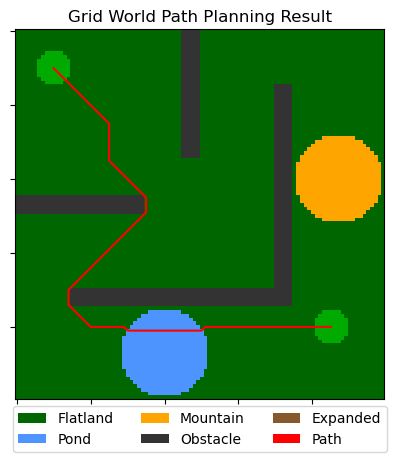

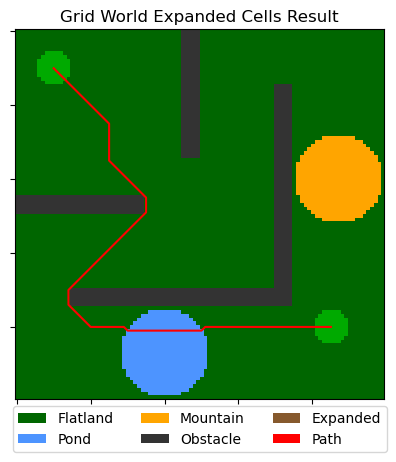

In [57]:
searcher.goal = (80, 85)
print("Initial planning...")
main(searcher)

The number of expanded states after changing the goal is 0. This is because the new goal's $g$, $v$ and parent values have already been computed the first time we ran the algorithm (because it was part of the expanded region). Therefore, the new goal's $g$ and $v$ values are consistent and we don't need to recompute them in computePath(). All that we have to do is trace the path from the new goals parent's.

**2.**

Path length: 136
Path cost: 149.1812408671319
Number of expanded states: 747


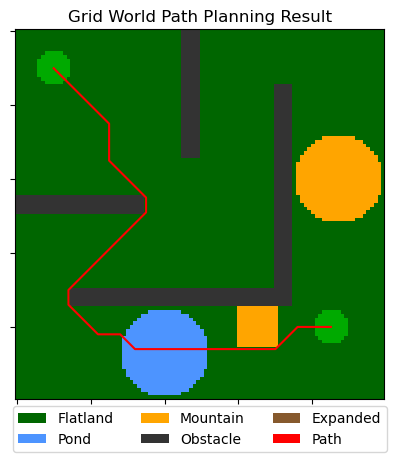

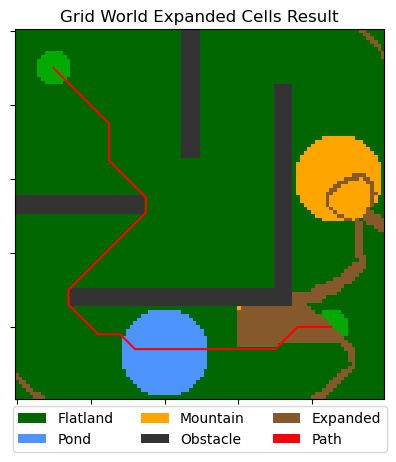

In [60]:
update_rows = list(range(75, 86))
update_cols = list(range(60, 71))

nodes_to_update = [(r, c) for r in update_rows for c in update_cols]

for node in nodes_to_update:
    searcher.update_costs([node[0]], [node[1]], Environment.MOUNTAIN)
main(searcher)

The path stays the same until it reaches the mountain where it changes to go around it. There are 747 reexpanded nodes which generally lie on the mountain region itself and to the right of it in the region surrounding the new path.

**3.**

Path length: 132
Path cost: 146.4177848998412
Number of expanded states: 2848


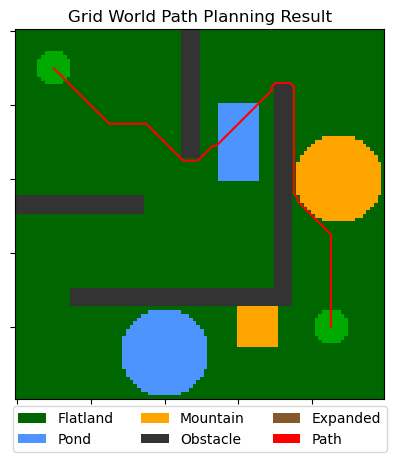

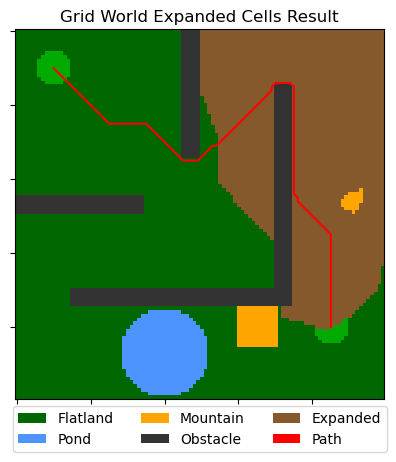

In [61]:
update_rows = list(range(20, 41))
update_cols = list(range(55, 66))

nodes_to_update = [(r, c) for r in update_rows for c in update_cols]

for node in nodes_to_update:
    searcher.update_costs([node[0]], [node[1]], Environment.POND)
main(searcher)

The algorithm computed a new optimal path which keeps towards the top of the world, goes through the new pond and travels downwards, approaching the goal from the top. There were 2828 re expanded nodes which generally lie on the new obstacle region, and in the rightmost third of the world. This corresponds to the region that the new optimal path is in. 